# PupilAnalysisPy - Tratamento do Sinal Pupilar

#### Este algoritmo serve para:
- Fazer o tratamento e preprocessamento do sinal
    - Remover células vazias (outliers)
    - Calcular perda de sinal
    - Reconstruir intervalos de perda de sinal (data missing)
    - Suaviar o sinal

#### Considerações importantes antes de exportar a base de dados do Tobii para o Python
- O equipamento Tobii Tx300 possui taxa de aquisição de 300Hz
- O Tobii Studio exporta até 86 variáveis
- Experimento longos ou com muitos voluntários pode gerar bases de dados muito grandes
    - Por exemplo, um experimento de 5 minutos realizado com 50 participantes irá gerar uma matriz com 4.500.000 de linhas (5 minutos X 60 segundos X 50 participantes X 300Hz = 4.500.000) 
    - Neste exemplo, ao exportar todas as variáveis possíveis será obtida uma matriz de [4500000x86] e isso irá gerar algumas dificuldades desnecessárias ao carregar a base de dados em outros programas. Então para otimizar o processo, evite exportar variáveis que não irá utilizar. 
- Variáveis essencialmente necessárias para este script:
    - ParticipantName
    - MediaName
    - PupilLeft
    - PupilRight

### Passo 0: Instalar e importar as bibliotecas necessárias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from tqdm import tqdm
import time
from skimage import io
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Passo 1: Importar a base de dados

In [2]:
# Insira o caminho onde a base de dados exportada foi armazenada 
# Coloque a letra r antes do caminho para evitar erro de interpretação da contrabarra \
df = pd.read_csv(r"C:\Users\Rafae\Desktop\EMOTION\Py_Emotion\Wilson2019\Emotion_Pictures_VF_Data_Export.tsv", sep="\t") #Lê arquivo

### Passo 2: Visualizar propriedades dos dados importados

In [3]:
# Verifique qual em qual pupila houve a maior perda de sinal
# Imprime quantodade de Amostras válidas (sem NaN) da Pupila Esquerda
print("Left pupil samples:",df.PupilLeft.count())
# Imprime quantodade de Amostras válidas (sem NaN) da Pupila Direita
print("Right pupil samples:",df.PupilRight.count()) 

Left pupil samples: 2763803
Right pupil samples: 2763671


In [4]:
# Filtra NaN e imprime nome de todos estímulos
print("Stimuli:",np.unique(df[df["MediaName"].notna()].MediaName)) 

Stimuli: ['1710.jpg' '2040.jpg' '2045.jpg' '2050.jpg' '2058.jpg' '2080.jpg'
 '2205.jpg' '2722.jpg' '3220.jpg' '6010.jpg' '7150.jpg' '7175.jpg'
 '7190.jpg' '7211.jpg' '7224.jpg' '7233.jpg' '7490.jpg' '7520.jpg'
 '7521.jpg' '7705.jpg' '8501.jpg' '8502.jpg' '8503.jpg' '9000.jpg'
 '9001.jpg' '9220.jpg']


In [5]:
# Imprime nome de todas os Participantes
print("ParticipantName:",np.unique(df.ParticipantName)) 

ParticipantName: ['P02' 'P03' 'P04' 'P05' 'P06' 'P07' 'P08' 'P09' 'P10' 'P11' 'P12' 'P13'
 'P14' 'P15' 'P17' 'P18' 'P19' 'P20' 'P21' 'P22' 'P23' 'P24' 'P25' 'P26'
 'P27' 'P28' 'P29' 'P30' 'P31' 'P32']


In [6]:
# Imprime nome de todas os Participantes
print("RecordingName:",np.unique(df.RecordingName))

RecordingName: ['Rec 02' 'Rec 03' 'Rec 04' 'Rec 05' 'Rec 06' 'Rec 07' 'Rec 08' 'Rec 09'
 'Rec 10' 'Rec 11' 'Rec 12' 'Rec 13' 'Rec 14' 'Rec 15' 'Rec 16' 'Rec 17'
 'Rec 18' 'Rec 19' 'Rec 20' 'Rec 21' 'Rec 22' 'Rec 23' 'Rec 24' 'Rec 25'
 'Rec 26' 'Rec 27' 'Rec 28' 'Rec 29' 'Rec 30' 'Rec 31' 'Rec 32']


In [7]:
# Verifique se é necessário excluir ou converter o tipo de alguma variável
print(df.info())# Imprime resumo dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189431 entries, 0 to 3189430
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ParticipantName    object 
 1   RecordingName      object 
 2   RecordingDuration  int64  
 3   MediaName          object 
 4   PupilLeft          float64
 5   PupilRight         float64
 6   Unnamed: 6         float64
dtypes: float64(3), int64(1), object(3)
memory usage: 170.3+ MB
None


### Passo 3: Limpar  base de dados
- Nesta etapa, em vez de excluir os dados que não for utilizar, selecione somente os dados que for utilizar e sobreescreva a base de dados

In [8]:
# Selecione somente as colunas que for utilizar
df = df[['RecordingName','MediaName','PupilLeft']]
# Renomeie a Pupila com maior quantidade de amostras gravadas para "Pupil"
df.rename(columns = {'PupilLeft':'Pupil'}, inplace = True)
display(df)

RecordingName MediaName  Pupil
0              Rec 02       NaN   3.22
1              Rec 02       NaN   3.25
2              Rec 02       NaN   3.25
3              Rec 02       NaN   3.23
4              Rec 02       NaN   3.22
...               ...       ...    ...
3189426        Rec 32       NaN    NaN
3189427        Rec 32       NaN    NaN
3189428        Rec 32       NaN    NaN
3189429        Rec 32       NaN    NaN
3189430        Rec 32       NaN    NaN

[3189431 rows x 3 columns]

In [9]:
# Gravações selecionadas 
rec = ['Rec 02', 'Rec 03', 'Rec 04', 'Rec 05', 'Rec 06', 'Rec 07', 'Rec 08', 'Rec 09', 'Rec 10', 'Rec 12',
       'Rec 13', 'Rec 14', 'Rec 15', 'Rec 16', 'Rec 17', 'Rec 18', 'Rec 19', 'Rec 20', 'Rec 21', 
       'Rec 23', 'Rec 24', 'Rec 25', 'Rec 26', 'Rec 27', 'Rec 28', 'Rec 29', 'Rec 30', 'Rec 31', 'Rec 32']
# Gravações removidas:
# Rec 11 - menos de 70% de gravação do sinal
# Rec 22 - perda de sinal com intervalo muito longo

# Selecione apenas os participantes da lista e substitua o conjunto de dados
df = df[df.RecordingName.isin(rec)] 
display(df)

RecordingName MediaName  Pupil
0              Rec 02       NaN   3.22
1              Rec 02       NaN   3.25
2              Rec 02       NaN   3.25
3              Rec 02       NaN   3.23
4              Rec 02       NaN   3.22
...               ...       ...    ...
3189426        Rec 32       NaN    NaN
3189427        Rec 32       NaN    NaN
3189428        Rec 32       NaN    NaN
3189429        Rec 32       NaN    NaN
3189430        Rec 32       NaN    NaN

[2991238 rows x 3 columns]

In [10]:
# Banco imagens originais
positive = ['8501.jpg', '2080.jpg', '2040.jpg', '8502.jpg', '2058.jpg', '1710.jpg', '8503.jpg']
neutral =  ['7150.jpg', '7175.jpg', '7190.jpg', '7224.jpg', '7233.jpg', '7490.jpg', '7705.jpg']
negative = ['2722.jpg', '9220.jpg', '7521.jpg', '9001.jpg', '2205.jpg', '6010.jpg', '3220.jpg']

stimuli = positive+neutral+negative

# Banco de imagens com mapa de atenção visual
st = ['8501reduced.png', '2080reduced.png', '2040reduced.png', '8502reduced.png',
      '2058reduced.png', '1710reduced.png', '8503reduced.png',
      '7150reduced.png', '7175reduced.png', '7190reduced.png', '7224reduced.png',
      '7233reduced.png', '7490reduced.png', '7705reduced.png',
      '2722reduced.png', '9220reduced.png', '7521reduced.png','9001reduced.png',
      '2205reduced.png', '6010reduced.png', '3220reduced.png']

df = df[df.MediaName.isin(stimuli)] 
display(df)

RecordingName MediaName  Pupil
4700           Rec 02  7705.jpg   3.17
4701           Rec 02  7705.jpg   3.20
4702           Rec 02  7705.jpg   3.17
4703           Rec 02  7705.jpg   3.26
4704           Rec 02  7705.jpg   3.22
...               ...       ...    ...
3184426        Rec 32  7175.jpg   4.27
3184427        Rec 32  7175.jpg   4.28
3184428        Rec 32  7175.jpg   4.27
3184429        Rec 32  7175.jpg   4.27
3184430        Rec 32  7175.jpg   4.29

[1136221 rows x 3 columns]

### Passo 4: Corrigir tipo e formato de dados

In [11]:
# substitui vírgula por ponto, usa o parâmetro regex para aplicar no df 
df["Pupil"] = df["Pupil"].replace(",",".", regex=True)
# Converte o tipo de dados para numérico (Float)
df["Pupil"] = pd.to_numeric(df["Pupil"]) 
display(df)

RecordingName MediaName  Pupil
4700           Rec 02  7705.jpg   3.17
4701           Rec 02  7705.jpg   3.20
4702           Rec 02  7705.jpg   3.17
4703           Rec 02  7705.jpg   3.26
4704           Rec 02  7705.jpg   3.22
...               ...       ...    ...
3184426        Rec 32  7175.jpg   4.27
3184427        Rec 32  7175.jpg   4.28
3184428        Rec 32  7175.jpg   4.27
3184429        Rec 32  7175.jpg   4.27
3184430        Rec 32  7175.jpg   4.29

[1136221 rows x 3 columns]

### Passo 5: Analisar a perda de sinal por participante
- Comumente utiliza-se o critério de 70% de amostras válidas
    - Verifique se a taxa de aquisição do sinal é igual o superior ao critério estipulado
    - Remova os participantes com taxa de aquisição abaixo do critério 

In [12]:
# Declara listas para armazenar a quantidade de amostras
lista1 = []; lista2 = []; lista3 = []  
# Laço de reptição para listar todos os participantes
for i in rec:
    # Filtra o participante
    dfi = df["RecordingName"]==i
     # Filtra amostras totais por participante
    lista1.append(len(df[dfi]))
    # Filtra somente as amostras gravadas, sem NaN
    lista2.append(len(df[dfi][df[dfi]["Pupil"].notna()]))
    # Calcula a taxa de gravação
    lista3.append(len(df[dfi][df[dfi]["Pupil"].notna()])/len(df[dfi]))
# Cria um relatório    
report = pd.DataFrame(data={'AllSamples':lista1,
                            'ValidSamples':lista2,
                            'RecRate':lista3}, index=[rec]) 
display(report)

AllSamples  ValidSamples   RecRate
Rec 02       75740         73606  0.971825
Rec 03       37871         35863  0.946978
Rec 04       37888         37016  0.976985
Rec 05       37874         36430  0.961874
Rec 06       37878         37329  0.985506
Rec 07       37869         36962  0.976049
Rec 08       37885         36584  0.965659
Rec 09       37872         36889  0.974044
Rec 10       37876         37797  0.997914
Rec 12       37884         37152  0.980678
Rec 13       37869         37039  0.978082
Rec 14       37884         35502  0.937124
Rec 15       37876         33933  0.895897
Rec 16       37864         35595  0.940075
Rec 17       37880         36617  0.966658
Rec 18       37871         30680  0.810119
Rec 19       37886         37790  0.997466
Rec 20       37875         30585  0.807525
Rec 21       37869         33610  0.887533
Rec 23       37885         36484  0.963020
Rec 24       37877         36839  0.972596
Rec 25       37858         35063  0.926171
Rec 26       37871         37600  0.992844
Rec 27       37870         34648  0.914919
Rec 28       37873         35779  0.944710
Rec 29       37867         32570  0.860116
Rec 30       37868         35512  0.937784
Rec 31       37867         34875  0.920987
Rec 32       37874         31609  0.834583

In [13]:
# Verifique se há algum participante com taxa de aquisição abaixo do critério
criterio = 0.7 # Denifinir critério (normalmente usa-se 70%)
dfc = report['RecRate'] < criterio 
display(report[dfc])
# Caso seja necessário remover algum participante, edite a 2º parte do passo 4.

Empty DataFrame
Columns: [AllSamples, ValidSamples, RecRate]
Index: []

### Passo 6 - Tratamento dos dados                               
- Remoção de outlier
- Reconstrução dos intervalos de perda de sinal (missing data)
- Suavização do sinal para remover ruído
- Normalização dos dados (change)

In [14]:
# Replace outliers to NaN
0.04 # Define um fator de filtro para outliers
factor = 0.04 
# Declara um novo df de apoio
df2 = pd.DataFrame(columns=['RecordingName','MediaName','Pupil']) 

for k in tqdm(range(0,len(rec))):
    for j in range(0,len(stimuli)):        
        # Filtra o participante e o estímulo
        dftemp = df.loc[(df["RecordingName"]==rec[k])&(df["MediaName"]==stimuli[j])] 
        # Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem crescente)
        for i in range(0,len(dftemp)-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan
        # Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem decrescente)  
        for i in range(len(dftemp)-1,0,-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan       
        # Faz a reconstrução do sinal por interpolação linear
        interpolated = dftemp.loc[:,'Pupil'].interpolate(method='linear',
                                                         limit_direction='both') 
        # Suaviza o sinal para remover os ruídos
        smoothed = savgol_filter(interpolated, 15, 3) 
        # Normaliza variação dos dados (change)
        change = smoothed-smoothed[0] 
        for i in range(0,len(dftemp)-1):
            dftemp.iat[i,2] = change[i]
        # Acresceta base sinal tratado na base de apoio    
        df2 = pd.concat([df2,dftemp.iloc[0:1800,0:3]])

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [07:57<00:00, 16.45s/it]


### Passo 7 - Análise visual do resultado da etapa de tratamento do sinal

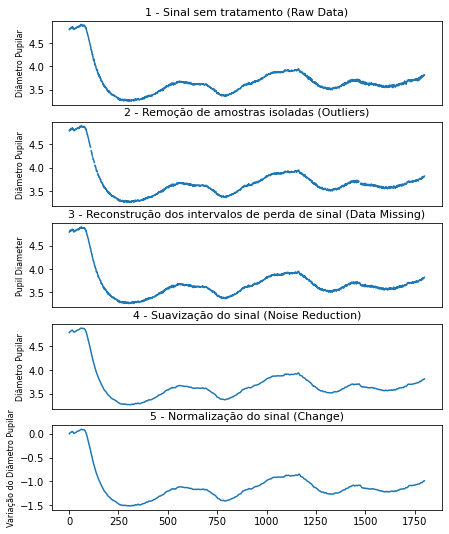

In [15]:
# Configura tamanho da imagem
plt.figure(figsize = (7, 9))

# Dados sem tratamento
# Filtra o participante e o estímulo
dftemp = df.loc[(df["RecordingName"]==rec[2])&(df["MediaName"]==stimuli[1])] 
x = list(range(1,len(dftemp['Pupil'])+1)) # Configura eixo das abscissas
y = dftemp["Pupil"] # Plota dado sem tratamento
plt.subplot(5, 1, 1)
plt.plot(x,y)
plt.title("1 - Sinal sem tratamento (Raw Data)", fontsize = 11)
plt.ylabel('Diâmetro Pupilar', fontsize = 8)
plt.xticks([]) 

# Remoção de outiliers
factor = 0.04 # Define um fator de filtro para outiliers
for i in range(0,len(dftemp)-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
# Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem decrescente) 
for i in range(len(dftemp)-1,0,-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan

# Plota dado sem Outliers        
y = dftemp["Pupil"] 
plt.subplot(5, 1, 2)
plt.plot(x,y)
plt.title("2 - Remoção de amostras isoladas (Outliers)", fontsize = 11)
plt.ylabel('Diâmetro Pupilar', fontsize = 8)
plt.xticks([]) 

# Faz a reconstrução do sinal por interpolação linear
y = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
plt.subplot(5, 1, 3)
plt.plot(x,y)
plt.title("3 - Reconstrução dos intervalos de perda de sinal (Data Missing)", fontsize = 11)
plt.ylabel('Pupil Diameter', fontsize = 8)
plt.xticks([]) 

# Suaviza o sinal para remover os ruídos
y = savgol_filter(y, 15, 3) 
x = list(range(1,len(y)+1))
plt.subplot(5, 1, 4)
plt.plot(x,y)
plt.title("4 - Suavização do sinal (Noise Reduction)", fontsize = 11)
plt.ylabel('Diâmetro Pupilar', fontsize = 8)
plt.xticks([]) 

# Dados após todas as etapas de tratamento
# Filtra o participante e o estímulo
y = df2.loc[(df2["RecordingName"]==rec[2])&(df2["MediaName"]==stimuli[1])]
# Configura eixo das abscissas
x = list(range(1,len(y['Pupil'])+1)) 
plt.subplot(5, 1, 5)
plt.plot(x,y['Pupil'])
plt.title("5 - Normalização do sinal (Change)", fontsize = 11)
plt.ylabel('Variação do Diâmetro Pupilar', fontsize = 8)

#plt.suptitle("Etapas de tratamento dos dados", fontsize = 20)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.35)

plt.savefig('Tratamento_do_sinal_emotion.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Passo 8 - Armazenagem a base de dados pré-processada
- Antes de seguir a diante, vamos criar um check point e armazenar a base de dados pré-processada.
- Esta etapa serve para ganhar tempo ao executar o código futuramente, pois a etapa de pré-processamento costuma ser demorada.

In [16]:
# Armazerna a base de dados pré-processada
df2.to_csv("base_pre_processada.csv", index = False, sep ='\t')

In [17]:
# Para retomar deste ponto:
# 1) Repita o passo 0: Instalar e importar as bibliotecas necessárias
# 2) Habilite o comando abaixo com o caminho para a base de dados
df2 = pd.read_csv(r"C:\Users\Rafae\Desktop\EMOTION\Py_Emotion\Wilson2019\base_pre_processada.csv", sep="\t")

## Análise de dados
- Organizar variáveis do sinal pupilar
- Visualizar o sinal da pupila de cada sujeito
- Calcular sinal médio por classe
- Visualizar sinal médio por classe
- Visualizar o sinal da pupila por estímulo
- Analisar as particularidades do sinal pupilar

### Passo 9: Configuração das funções para análise de dados

In [18]:
# Função para calcular o sinal médio por classe
def sign_class(rec,id):
    # pré-aloca espaço para armazenar sinal de pupila
    z = np.zeros(shape=(len(rec), 1800)) 
    k = 0 # Inicia contador
    for i in rec:
        # Filtra sujeito e estímulo
        w = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==id)] 
        z[k,:]=w['Pupil'] # Armazena sinal dos sujeitos 
        k = k+1 # Incrementa contador
    y = np.mean(z, axis=0) # Cacula a média da classe 
    x = list(range(1,len(y)+1)) # Configura o eixo das abscissas
    g = plt.plot(x,y, color = 'black') # Imprime sinal médio
    return g

In [19]:
# Função para imprimir imagem original (estímulo apresentado), sinal de cada sujeito e sinal médio por classe
def result_id(id1,id2):
    plt.figure(figsize=(15,3)) # Configura a área de plotagem
    plt.subplot(1,3,1) # Configura a posição de impressão
    plt.imshow(io.imread(id2)) # Imprime imagem original
    plt.title('Mapa de atenção visual - id: ' + id1[:4], fontsize=11) # Configura o título
    plt.axis('off') # Remove eixos
    
    plt.subplot(1,3,2) # Configura a posição de impressão
    for i in rec:
        # Filter the subjects and stimuli
        y = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==id1)] 
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Set subject's pupil sign
    plt.title("Sinal pupilar de todos observadores", fontsize = 11) # Insert title
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 9) # Insere o rótulo do eixo das ordenadas
    plt.xlabel('Tempo (s)', fontsize = 9) # Insere o rótulo do eixo das abscissas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    
    plt.subplot(1,3,3) # Configura a posição de impressão
    sign_class(rec,id1) # Imprime o sinal médio 
    plt.title("Sinal médio de todos observadores", fontsize = 11) # Insere o título
    plt.ylabel('Variação do diâmetro pupilar (mm)') # Insere o rótulo do eixo das ordenadas
    plt.xlabel('Tempo (s)', fontsize = 9) # Insere o rótulo do eixo das abscissas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    
    plt.savefig('Resultado_id_'+id1[:4]+'.pdf', format='pdf', bbox_inches='tight')
    return

### Passo 10: Visualização das características do sinal pupilar

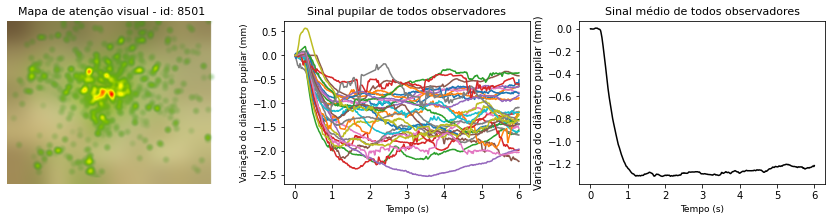

In [20]:
result_id(stimuli[0],st[0]) 

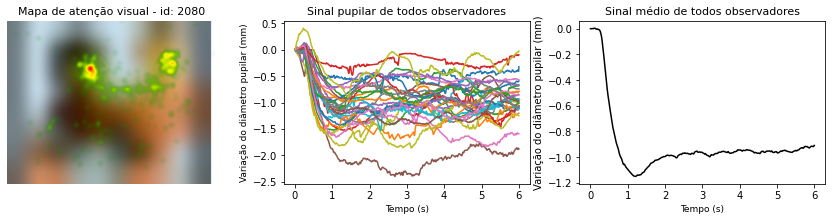

In [21]:
result_id(stimuli[1],st[1]) 

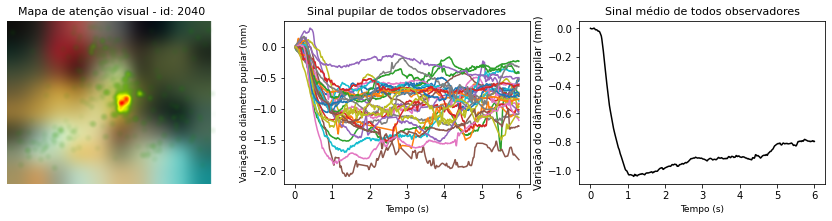

In [22]:
result_id(stimuli[2],st[2]) 

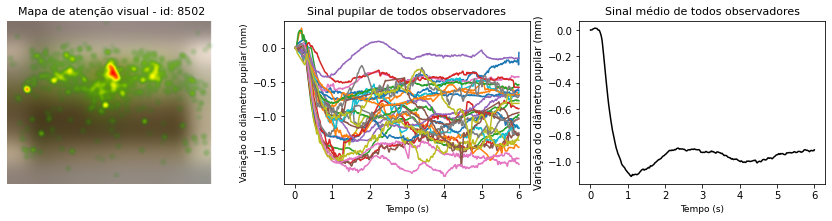

In [23]:
result_id(stimuli[3],st[3]) 

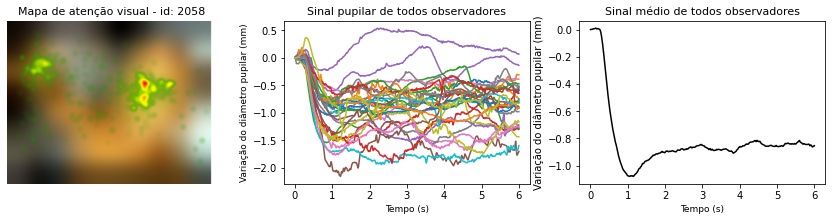

In [24]:
result_id(stimuli[4],st[4]) 

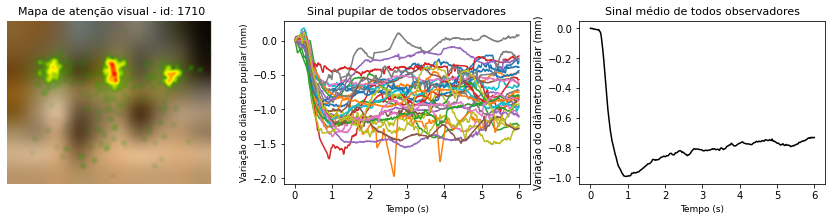

In [25]:
result_id(stimuli[5],st[5]) 

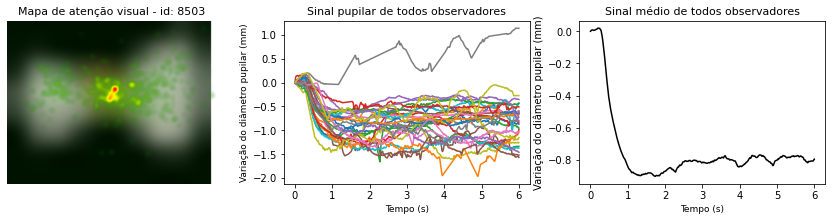

In [26]:
result_id(stimuli[6],st[6]) 

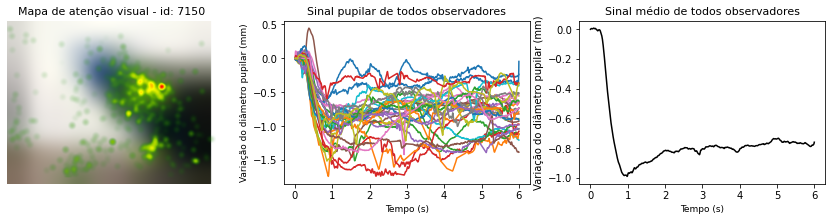

In [27]:
result_id(stimuli[7],st[7]) 

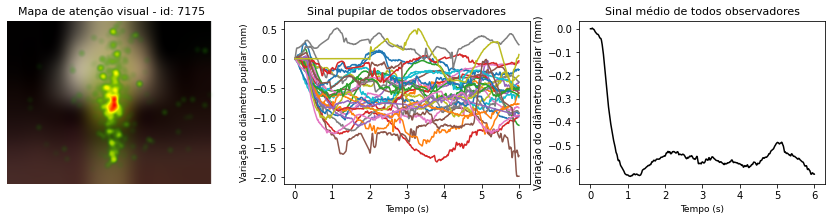

In [28]:
result_id(stimuli[8],st[8])

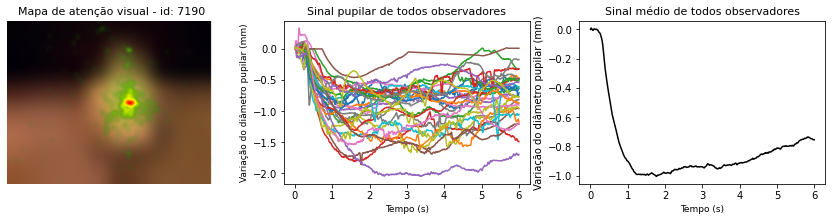

In [29]:
result_id(stimuli[9],st[9]) 

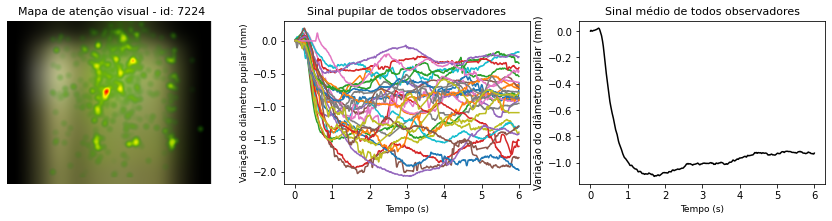

In [30]:
result_id(stimuli[10],st[10])

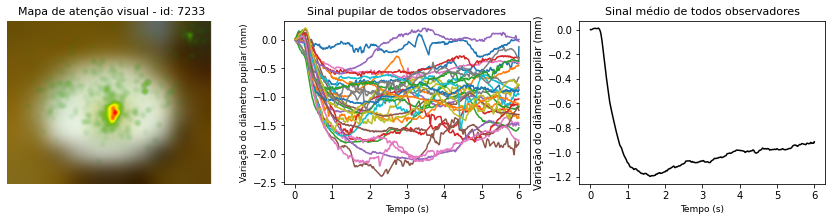

In [31]:
result_id(stimuli[11],st[11]) 

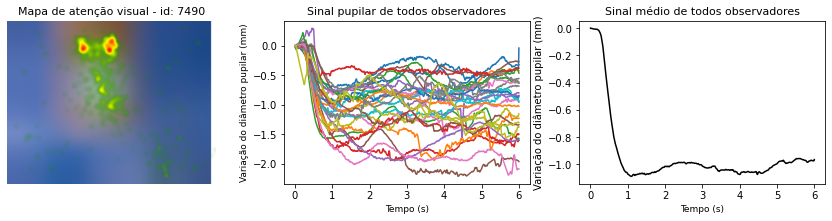

In [32]:
result_id(stimuli[12],st[12]) 

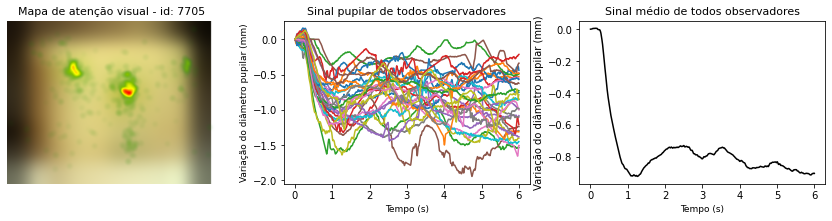

In [33]:
result_id(stimuli[13],st[13]) 

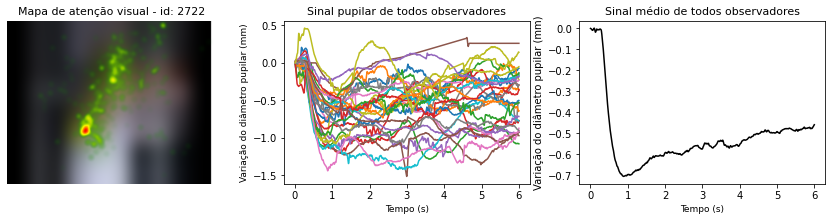

In [34]:
result_id(stimuli[14],st[14]) 

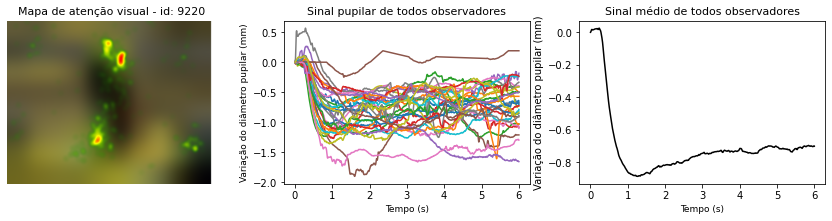

In [35]:
result_id(stimuli[15],st[15])

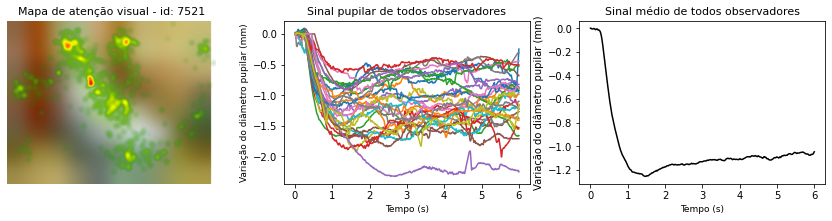

In [36]:
result_id(stimuli[16],st[16]) 

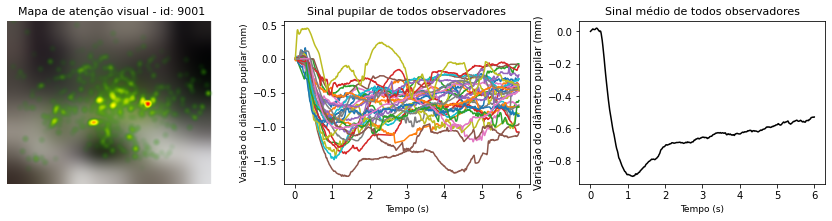

In [37]:
result_id(stimuli[17],st[17]) 

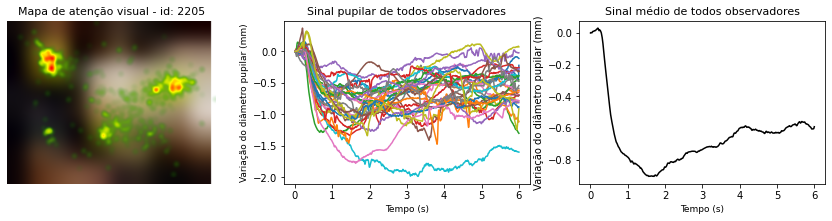

In [38]:
result_id(stimuli[18],st[18]) 

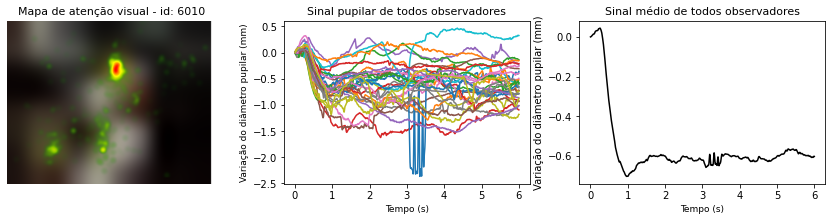

In [39]:
result_id(stimuli[19],st[19]) 

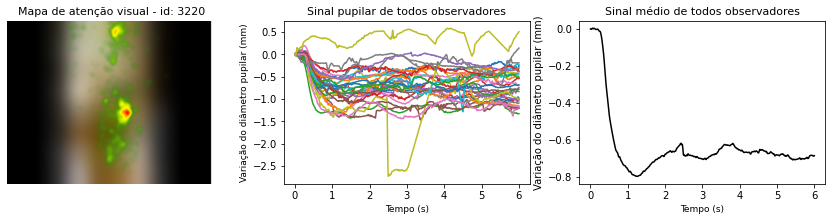

In [40]:
result_id(stimuli[20],st[20]) 

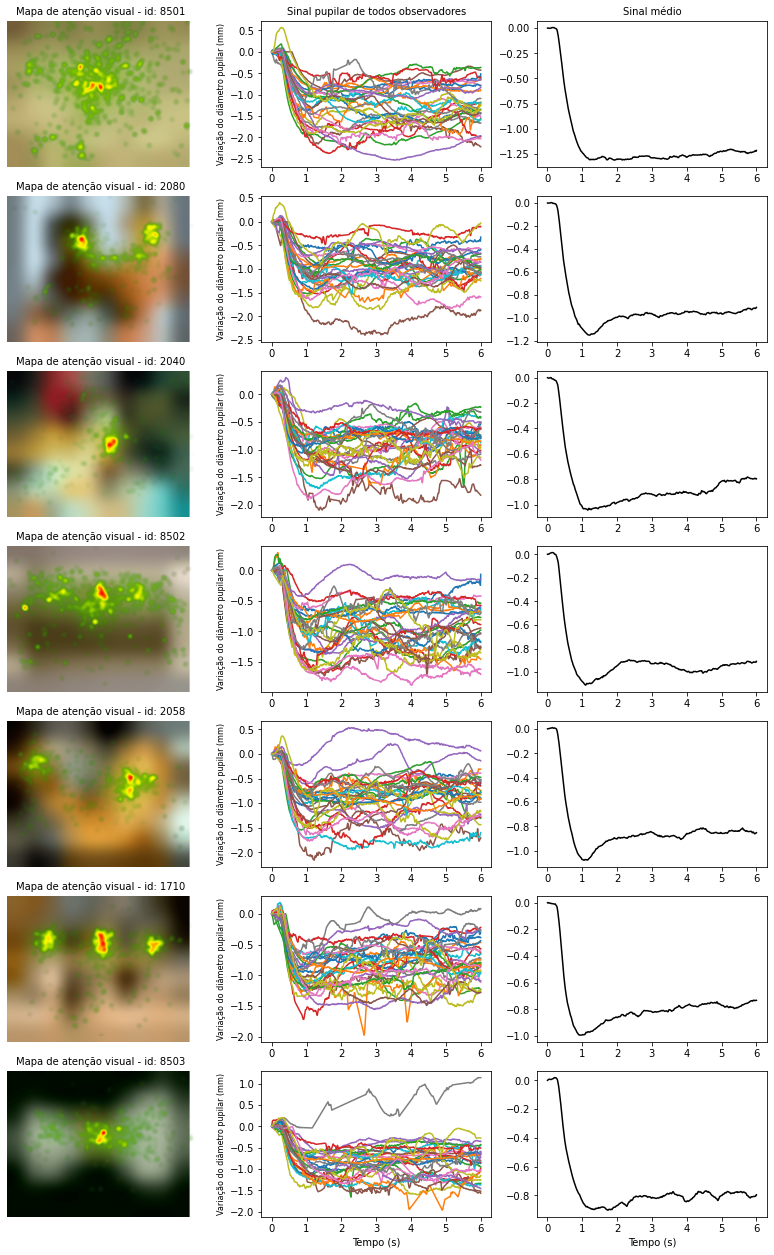

In [49]:
from matplotlib.ticker import StrMethodFormatter  # Formatação dos valores do eixo y
plt.figure(figsize=(14,22)) # Configura a área de plotagem
img = 1
for j in st[0:7]:
    plt.subplot(7,3,img) # Configura a posição de impressão
    plt.imshow(io.imread(j)) # Imprime imagem original
    plt.title('Mapa de atenção visual - id: ' + j[:4], fontsize=10) # Configura o rótulo da imagem
    plt.axis('off') # Remove eixos
    img = img+3

img = 2    
for sti in positive:
    plt.subplot(7,3,img) # Configura a posição de impressão
    for i in rec:
        y = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==sti)] 
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Imprime o sinal do sujeito
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+1
    plt.subplot(7,3,img) # Configura a posição de impressão
    sign_class(rec,sti) # Imprime o sinal médio 
    #plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+2
    
#Configuração dos títulos e rótulos
plt.subplot(7,3,2) # Configura a posição de impressão
plt.title("Sinal pupilar de todos observadores", fontsize = 10) # Insert title
plt.subplot(7,3,3) # Configura a posição de impressão
plt.title("Sinal médio", fontsize = 10) # Insere o título
plt.subplot(7,3,20) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas
plt.subplot(7,3,21) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas

plt.savefig('Total_positive.pdf', format='pdf', bbox_inches='tight')

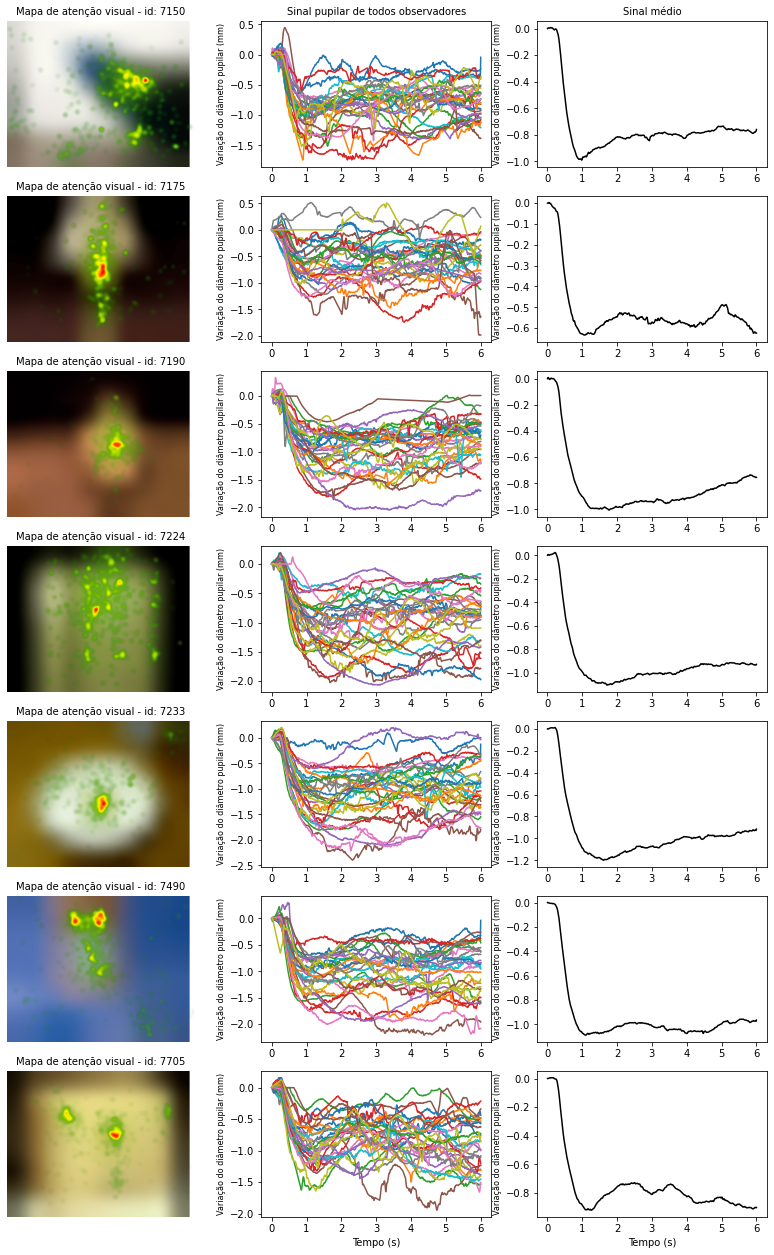

In [50]:
plt.figure(figsize=(14,22)) # Configura a área de plotagem
img = 1
for j in st[7:14]:
    plt.subplot(7,3,img) # Configura a posição de impressão
    plt.imshow(io.imread(j)) # Imprime imagem original
    plt.title('Mapa de atenção visual - id: ' + j[:4], fontsize=10) # Configura o título
    plt.axis('off') # Remove eixos
    img = img+3

img = 2    
for sti in neutral:
    plt.subplot(7,3,img) # Configura a posição de impressão
    for i in rec:
        y = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==sti)] 
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Set subject's pupil sign
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+1
    plt.subplot(7,3,img) # Configura a posição de impressão
    sign_class(rec,sti) # Imprime o sinal médio 
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+2

#Configuração dos títulos e rótulos
plt.subplot(7,3,2) # Configura a posição de impressão
plt.title("Sinal pupilar de todos observadores", fontsize = 10) # Insert title
plt.subplot(7,3,3) # Configura a posição de impressão
plt.title("Sinal médio", fontsize = 10) # Insere o título
plt.subplot(7,3,20) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas
plt.subplot(7,3,21) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas

plt.savefig('Total_neutral.pdf', format='pdf', bbox_inches='tight', dpi = 10)

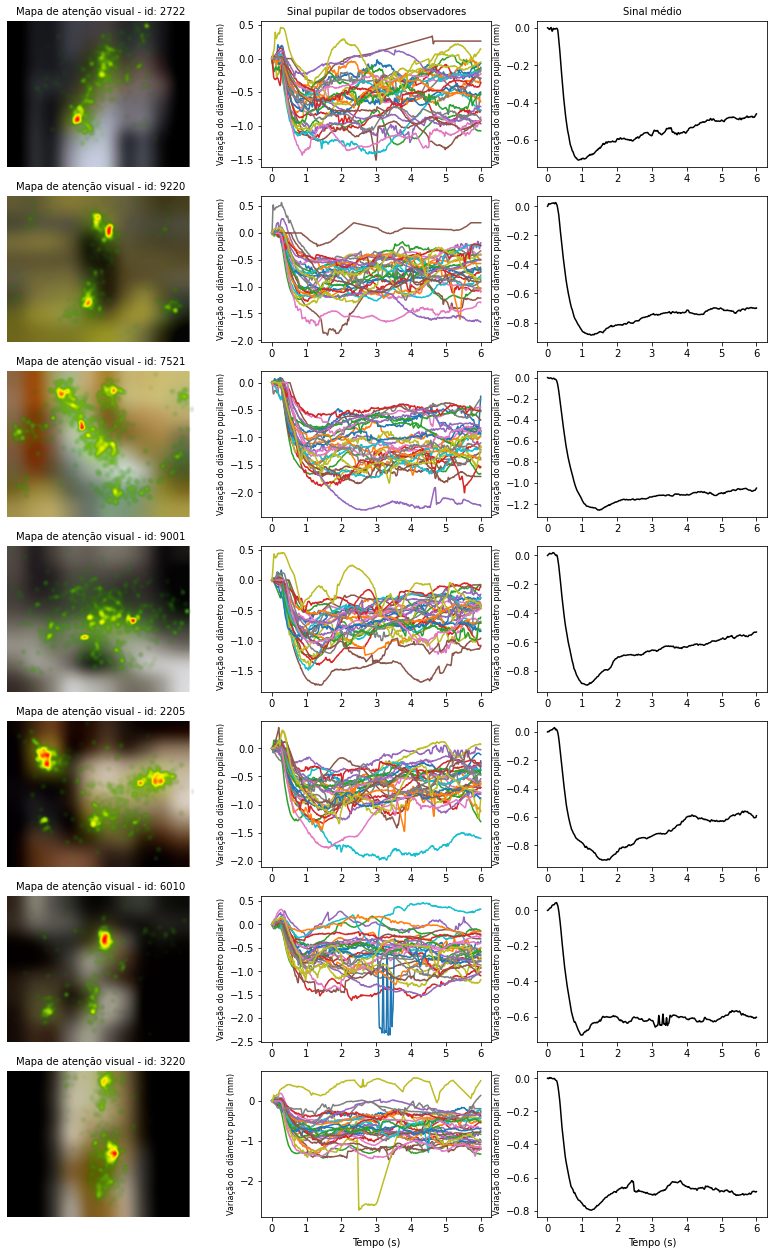

In [51]:
plt.figure(figsize=(14,22)) # Configura a área de plotagem
img = 1
for j in st[14:21]:
    plt.subplot(7,3,img) # Configura a posição de impressão
    plt.imshow(io.imread(j)) # Imprime imagem original
    plt.title('Mapa de atenção visual - id: ' + j[:4], fontsize=10) # Configura o título
    plt.axis('off') # Remove eixos
    img = img+3

img = 2    
for sti in negative:
    plt.subplot(7,3,img) # Configura a posição de impressão
    for i in rec:
        y = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==sti)] 
        x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
        plt.plot(x,y['Pupil']) # Set subject's pupil sign
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+1
    plt.subplot(7,3,img) # Configura a posição de impressão
    sign_class(rec,sti) # Imprime o sinal médio 
    plt.ylabel('Variação do diâmetro pupilar (mm)', fontsize = 8) # Insere o rótulo do eixo das ordenadas
    plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])
    img = img+2

#Configuração dos títulos e rótulos
plt.subplot(7,3,2) # Configura a posição de impressão
plt.title("Sinal pupilar de todos observadores", fontsize = 10) # Insert title
plt.subplot(7,3,3) # Configura a posição de impressão
plt.title("Sinal médio", fontsize = 10) # Insere o título
plt.subplot(7,3,20) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas
plt.subplot(7,3,21) # Configura a posição de impressão
plt.xlabel('Tempo (s)', fontsize = 10) # Insere o rótulo do eixo das abscissas

plt.savefig('Total_negative.pdf', format='pdf', bbox_inches='tight')

In [52]:
# Função para calcular o sinal médio por classe e estímulo
def sign_class_cat(classe,stimuli):
    # Pré-aloca espaco para armazenar sinal pupilar
    z = np.zeros(shape=(len(classe)*len(stimuli), 1800))  
    k = 0 # Inicia contador
    for i in classe:
        for j in stimuli:
            # Filtra sujeito e estímulo
            w = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==j)] 
            z[k,:]=w['Pupil'] # Armazena sinal dos sujeitos
            k = k+1 # Incrementa contador
    y = np.mean(z, axis=0) # Calcula a média da classe
    x = list(range(1,len(y)+1)) # Configura o eixo das abscissas
    return y

In [53]:
# Obtém o sinal médio por classe e tipo de estímulo
e_positive = sign_class_cat(rec,positive)
e_neutral = sign_class_cat(rec,neutral)
e_negative = sign_class_cat(rec,negative)

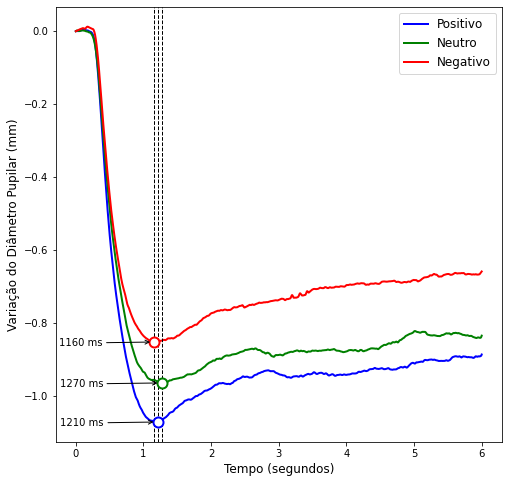

In [54]:
# Configura a área de plotagem
fig, ax = plt.subplots(figsize=(8,8))
x = list(range(1,len(e_positive)+1)) # Configura o eixo das abscissas
g = plt.plot(x,e_positive,'blue',linewidth = 2) # Imprime o sinal médio - classe positiva
g = plt.plot(x,e_neutral,'green',linewidth = 2) # Imprime o sinal médio - classe neutra
g = plt.plot(x,e_negative,'red',linewidth = 2) # Imprime o sinal médio - classe negativa

g = plt.axvline(x = [np.argmin(e_positive)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmin(e_neutral)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmin(e_negative)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)

#g = plt.text(x[np.argmin(e_positive)]+70, e_positive[np.argmin(e_positive)]-0.03,
#             str(round(np.argmin(e_positive)/300*1000))+str(' ms'), fontsize=10)
#g = plt.text(x[np.argmin(e_neutral)]+35, e_neutral[np.argmin(e_neutral)]+0.05,
#             str(round(np.argmin(e_neutral)/300*1000))+str(' ms'), fontsize=10)
#g = plt.text(x[np.argmin(e_negative)]+70, e_negative[np.argmin(e_negative)]+0.1,
#             str(round(np.argmin(e_negative)/300*1000))+str(' ms'), fontsize=10)

g = plt.plot(x[np.argmin(e_positive)], e_positive[np.argmin(e_positive)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_neutral)], e_neutral[np.argmin(e_neutral)], 'o', 
             markersize=10, markeredgecolor="green", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_negative)], e_negative[np.argmin(e_negative)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)

g = plt.legend(['Positivo','Neutro','Negativo'],fontsize=12) # Insert legend
g = plt.ylabel('Variação do Diâmetro Pupilar (mm)',fontsize=12) # Insert label of the ordinate axis
g = plt.xlabel('Tempo (segundos)',fontsize=12) # Insert label of the abscissa axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])

ax.annotate(str(round(np.argmin(e_positive)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_positive)]-10, e_positive[np.argmin(e_positive)]),
            xycoords='data', xytext=(-95,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

ax.annotate(str(round(np.argmin(e_neutral)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_neutral)]-10, e_neutral[np.argmin(e_neutral)]),
            xycoords='data', xytext=(-100,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

ax.annotate(str(round(np.argmin(e_negative)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_negative)]-10, e_negative[np.argmin(e_negative)]),
            xycoords='data', xytext=(-93,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

plt.savefig('change1.pdf', format='pdf', bbox_inches='tight')

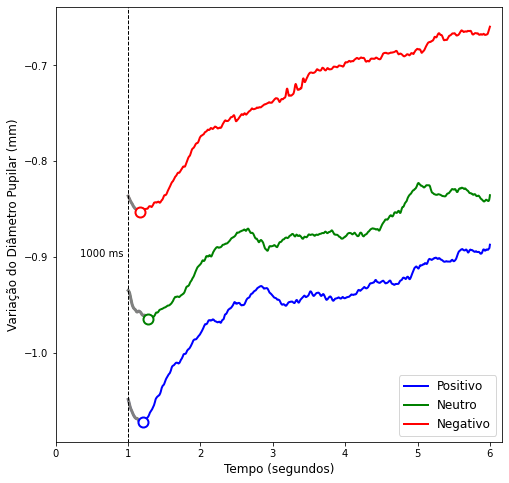

In [55]:
plt.figure(figsize=(8,8)) # Set plot area
x = list(range(1,len(e_positive[300:1800])+1)) # Set the abscissa axis
g = plt.plot(x,e_positive[300:1800],'blue',linewidth = 2) # Print mean sign
g = plt.plot(x,e_neutral[300:1800],'green',linewidth = 2) # Print mean sign
g = plt.plot(x,e_negative[300:1800],'red',linewidth = 2) # Print mean sign

g = plt.plot(x[0:50],e_positive[300:350],'grey',linewidth = 3) # Print mean sign
g = plt.plot(x[0:80],e_neutral[300:380],'grey',linewidth = 3) # Print mean sign
g = plt.plot(x[0:50],e_negative[300:350],'grey',linewidth = 3) # Print mean sign

g = plt.axvline(x = 0, ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(-200, -0.9,'1000 ms', fontsize=10)

g = plt.plot(x[np.argmin(e_positive)-300], e_positive[np.argmin(e_positive)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_neutral)-300], e_neutral[np.argmin(e_neutral)], 'o', 
             markersize=10, markeredgecolor="green", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_negative)-300], e_negative[np.argmin(e_negative)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)

g = plt.xlim(-300,1550)
g = plt.legend(['Positivo','Neutro','Negativo'],fontsize=12) # Insert legend
g = plt.ylabel('Variação do Diâmetro Pupilar (mm)',fontsize=12) # Insert label of the ordinate axis
g = plt.xlabel('Tempo (segundos)',fontsize=12) # Insert label of the abscissa axis
g = plt.xticks(ticks=[-300,0,300,600,900,1200,1500], labels=[0,1,2,3,4,5,6])
plt.savefig('change2.pdf', format='pdf', bbox_inches='tight')

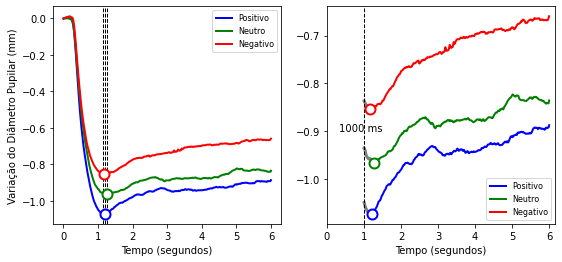

In [89]:
# Configura a área de plotagem

plt.figure(figsize=(9,4)) # Configura a área de plotagem
#fig, ax = plt.subplots(figsize=(8,8))
plt.subplot(1,2,1) # Configura a posição de impressão
x = list(range(1,len(e_positive)+1)) # Configura o eixo das abscissas
g = plt.plot(x,e_positive,'blue',linewidth = 2) # Imprime o sinal médio - classe positiva
g = plt.plot(x,e_neutral,'green',linewidth = 2) # Imprime o sinal médio - classe neutra
g = plt.plot(x,e_negative,'red',linewidth = 2) # Imprime o sinal médio - classe negativa

g = plt.axvline(x = [np.argmin(e_positive)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmin(e_neutral)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.axvline(x = [np.argmin(e_negative)], ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)

g = plt.plot(x[np.argmin(e_positive)], e_positive[np.argmin(e_positive)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_neutral)], e_neutral[np.argmin(e_neutral)], 'o', 
             markersize=10, markeredgecolor="green", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_negative)], e_negative[np.argmin(e_negative)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)

g = plt.legend(['Positivo','Neutro','Negativo'],fontsize=8) # Insert legend
g = plt.ylabel('Variação do Diâmetro Pupilar (mm)',fontsize=10) # Insert label of the ordinate axis
g = plt.xlabel('Tempo (segundos)',fontsize=10) # Insert label of the abscissa axis
g = plt.xticks(ticks=[0,300,600,900,1200,1500,1800], labels=[0,1,2,3,4,5,6])

ax.annotate(str(round(np.argmin(e_positive)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_positive)]-10, e_positive[np.argmin(e_positive)]),
            xycoords='data', xytext=(-95,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

ax.annotate(str(round(np.argmin(e_neutral)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_neutral)]-10, e_neutral[np.argmin(e_neutral)]),
            xycoords='data', xytext=(-100,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

ax.annotate(str(round(np.argmin(e_negative)/300*1000))+str(' ms'),
            xy=(x[np.argmin(e_negative)]-10, e_negative[np.argmin(e_negative)]),
            xycoords='data', xytext=(-93,-4),
            textcoords='offset points', arrowprops=dict(arrowstyle="->"))

plt.subplot(1,2,2) # Configura a posição de impressão
x = list(range(1,len(e_positive[300:1800])+1)) # Set the abscissa axis
g = plt.plot(x,e_positive[300:1800],'blue',linewidth = 2) # Print mean sign
g = plt.plot(x,e_neutral[300:1800],'green',linewidth = 2) # Print mean sign
g = plt.plot(x,e_negative[300:1800],'red',linewidth = 2) # Print mean sign

g = plt.plot(x[0:50],e_positive[300:350],'grey',linewidth = 3) # Print mean sign
g = plt.plot(x[0:80],e_neutral[300:380],'grey',linewidth = 3) # Print mean sign
g = plt.plot(x[0:50],e_negative[300:350],'grey',linewidth = 3) # Print mean sign

g = plt.axvline(x = 0, ymin = -0.025, ymax = 1,color = 'black', linestyle = '--', linewidth = 1)
g = plt.text(-200, -0.9,'1000 ms', fontsize=10)

g = plt.plot(x[np.argmin(e_positive)-300], e_positive[np.argmin(e_positive)], 'o', 
             markersize=10, markeredgecolor="blue", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_neutral)-300], e_neutral[np.argmin(e_neutral)], 'o', 
             markersize=10, markeredgecolor="green", markerfacecolor="white", markeredgewidth=2)
g = plt.plot(x[np.argmin(e_negative)-300], e_negative[np.argmin(e_negative)], 'o', 
             markersize=10, markeredgecolor="red", markerfacecolor="white", markeredgewidth=2)

g = plt.xlim(-300,1550)
g = plt.legend(['Positivo','Neutro','Negativo'],fontsize=8) # Insert legend
#g = plt.ylabel('Variação do Diâmetro Pupilar (mm)',fontsize=10) # Insert label of the ordinate axis
g = plt.xlabel('Tempo (segundos)',fontsize=10) # Insert label of the abscissa axis
g = plt.xticks(ticks=[-300,0,300,600,900,1200,1500], labels=[0,1,2,3,4,5,6])

plt.savefig('change.pdf', format='pdf', bbox_inches='tight')

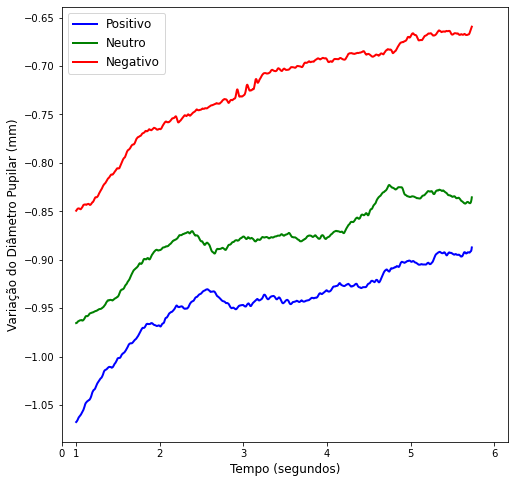

In [56]:
plt.figure(figsize=(8,8)) # Set plot area
x = list(range(1,len(e_positive[np.argmin(e_neutral):1800])+1)) # Set the abscissa axis
g = plt.plot(x,e_positive[np.argmin(e_neutral):1800],'blue',linewidth = 2) # Print mean sign
g = plt.plot(x,e_neutral[np.argmin(e_neutral):1800],'green',linewidth = 2) # Print mean sign
g = plt.plot(x,e_negative[np.argmin(e_neutral):1800],'red',linewidth = 2) # Print mean sign

#g = plt.plot(x[0:50],e_positive[300:350],'white',linewidth = 4) # Print mean sign
#g = plt.plot(x[0:80],e_neutral[300:380],'white',linewidth = 4) # Print mean sign
#g = plt.plot(x[0:50],e_negative[300:350],'white',linewidth = 4) # Print mean sign

g = plt.xlim(-50,1550)
g = plt.legend(['Positivo','Neutro','Negativo'],fontsize=12) # Insert legend
g = plt.ylabel('Variação do Diâmetro Pupilar (mm)',fontsize=12) # Insert label of the ordinate axis
g = plt.xlabel('Tempo (segundos)',fontsize=12) # Insert label of the abscissa axis
g = plt.xticks(ticks=[-50,0,300,600,900,1200,1500], labels=[0,1,2,3,4,5,6])
plt.savefig('change3.pdf', format='pdf', bbox_inches='tight')

### Passo 11: Análise da correlação e teste hipóteses por classe

In [62]:
# Prepara dataframe para análise de correlação
df_cor = pd.DataFrame({
    'Positivo': e_positive,
    'Neutro': e_neutral,
    'Negativo': e_negative
})

In [63]:
# Calcula a correlação das curvas
correlation = df_cor.corr()
correlation

Positivo    Neutro  Negativo
Positivo  1.000000  0.997926  0.991807
Neutro    0.997926  1.000000  0.986551
Negativo  0.991807  0.986551  1.000000

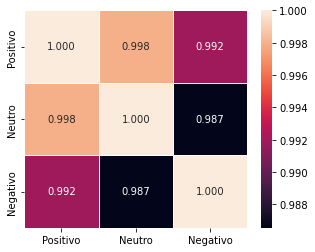

In [65]:
# Imprime a matriz de correlação
plt.figure(figsize=(5,4)) # Set plot area
ax = plt.axes()
plot = sns.heatmap(correlation, cmap = "rocket", annot = True, fmt=".3f", linewidths=1, ax = ax)
#ax.set_title('Correlação do sinal pupilar por estímulo', fontsize = 12)
plt.savefig('correlation1.pdf', format='pdf', bbox_inches='tight')

In [66]:
# Cria dataframe para armazenar dados
df_anova = pd.DataFrame({'Signal': df_cor.unstack(),
                         'Class': np.repeat(['Positivo','Neutro','Negativo',],repeats=len(e_positive))})
# Realiza comparações pareadas múltiplas (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_anova['Signal'], groups=df_anova['Class'], alpha=0.05)
print(m_comp)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
Negativo   Neutro  -0.1318 0.001 -0.1489 -0.1147   True
Negativo Positivo  -0.1992 0.001 -0.2164 -0.1821   True
  Neutro Positivo  -0.0674 0.001 -0.0845 -0.0503   True
-------------------------------------------------------


In [67]:
# Aplica análise da variância - ANOVA
f_oneway(e_positive, e_neutral, e_negative)

F_onewayResult(statistic=384.76235819115675, pvalue=6.152819221119179e-157)

### Passo 12: Análise da correlação e teste de hipóteses por estímulo

In [68]:
# Função para calcular o sinal médio por estímulo
def sign_stimuli(rec,stimuli):
    # Pré-aloca espaco para armazenar sinal pupilar
    z = np.zeros(shape=(len(rec), 1800))
    y = np.zeros(shape=(len(stimuli), 1800))
    q = 0 # Inicia contador
    for j in stimuli:
        k = 0 # Inicia contador
        for i in rec:
            w = df2.loc[(df2["RecordingName"]==i)&(df2["MediaName"]==j)] 
            z[k,:]=w['Pupil'] # Armazena sinal dos sujeitos
            k = k+1 # Incrementa contador
        y[q,:] = np.mean(z, axis=0) # Calcula a média da classe
        q = q+1 # Incrementa contador
    return y

In [69]:
s_positive = sign_stimuli(rec,positive)
s_neutral = sign_stimuli(rec,neutral)
s_negative = sign_stimuli(rec,negative)

In [70]:
# Classe de estímulos positivos
# Prepara dataframe para análise de correlação
df_cor_positive = pd.DataFrame({
    positive[0][:4]: s_positive[0],
    positive[1][:4]: s_positive[1],
    positive[2][:4]: s_positive[2],
    positive[3][:4]: s_positive[3],
    positive[4][:4]: s_positive[4],
    positive[5][:4]: s_positive[5],
    positive[6][:4]: s_positive[6]
})
# Calcula a correlação das curvas 
correlation_positive = df_cor_positive.corr()
correlation_positive

8501      2080      2040      8502      2058      1710      8503
8501  1.000000  0.971363  0.968517  0.962901  0.948574  0.913209  0.990444
2080  0.971363  1.000000  0.985332  0.989934  0.992383  0.976941  0.984253
2040  0.968517  0.985332  1.000000  0.971356  0.976152  0.965512  0.979834
8502  0.962901  0.989934  0.971356  1.000000  0.983734  0.962001  0.973848
2058  0.948574  0.992383  0.976152  0.983734  1.000000  0.986952  0.967332
1710  0.913209  0.976941  0.965512  0.962001  0.986952  1.000000  0.939712
8503  0.990444  0.984253  0.979834  0.973848  0.967332  0.939712  1.000000

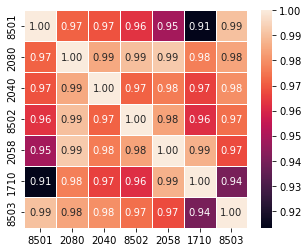

In [71]:
# Imprime o mapa de correlação - estímulos posistivos
plt.figure(figsize=(5,4))
ax = plt.axes()
sns.heatmap(correlation_positive, annot = True, fmt=".2f", linewidths=.6, ax = ax)
#ax.set_title('Estímulos Positivos', fontsize = 12)
plt.savefig('correlation_positive.pdf', format='pdf', bbox_inches='tight')

In [72]:
# Cria dataframa para armazenar dados
df_anova_positive = pd.DataFrame({'Signal': df_cor_positive.unstack(),
                                  'Class': np.repeat([positive,],repeats=len(e_positive))})
# Realiza comparações pareadas múltiplas (Tukey HSD)
m_comp_positive = pairwise_tukeyhsd(endog=df_anova_positive['Signal'], groups=df_anova_positive['Class'], alpha=0.05)
print(m_comp_positive)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
1710.jpg 2040.jpg  -0.0741  0.001 -0.0983 -0.0499   True
1710.jpg 2058.jpg  -0.0534  0.001 -0.0776 -0.0292   True
1710.jpg 2080.jpg  -0.1405  0.001 -0.1648 -0.1163   True
1710.jpg 8501.jpg  -0.3833  0.001 -0.4075  -0.359   True
1710.jpg 8502.jpg  -0.1218  0.001  -0.146 -0.0975   True
1710.jpg 8503.jpg   0.0203 0.1688 -0.0039  0.0446  False
2040.jpg 2058.jpg   0.0207 0.1507 -0.0035   0.045  False
2040.jpg 2080.jpg  -0.0664  0.001 -0.0907 -0.0422   True
2040.jpg 8501.jpg  -0.3091  0.001 -0.3334 -0.2849   True
2040.jpg 8502.jpg  -0.0477  0.001 -0.0719 -0.0234   True
2040.jpg 8503.jpg   0.0944  0.001  0.0702  0.1187   True
2058.jpg 2080.jpg  -0.0872  0.001 -0.1114 -0.0629   True
2058.jpg 8501.jpg  -0.3299  0.001 -0.3541 -0.3057   True
2058.jpg 8502.jpg  -0.0684  0.001 -0.0926 -0.0442   True
2058.jpg 8503.jpg   0.0737  0.0

In [73]:
# Classe de estímulos neutros
# Prepara dataframe para análise de correlação
df_cor_neutral = pd.DataFrame({
    neutral[0][:4]: s_neutral[0],
    neutral[1][:4]: s_neutral[1],
    neutral[2][:4]: s_neutral[2],
    neutral[3][:4]: s_neutral[3],
    neutral[4][:4]: s_neutral[4],
    neutral[5][:4]: s_neutral[5],
    neutral[6][:4]: s_neutral[6]
})
# Calcula a correlação das curvas 
correlation_neutral = df_cor_neutral.corr()
correlation_neutral

7150      7175      7190      7224      7233      7490      7705
7150  1.000000  0.975912  0.942677  0.953003  0.957273  0.964360  0.934172
7175  0.975912  1.000000  0.933575  0.950997  0.941567  0.979754  0.967809
7190  0.942677  0.933575  1.000000  0.989673  0.990877  0.967165  0.881709
7224  0.953003  0.950997  0.989673  1.000000  0.995173  0.977202  0.918480
7233  0.957273  0.941567  0.990877  0.995173  1.000000  0.967871  0.905113
7490  0.964360  0.979754  0.967165  0.977202  0.967871  1.000000  0.963556
7705  0.934172  0.967809  0.881709  0.918480  0.905113  0.963556  1.000000

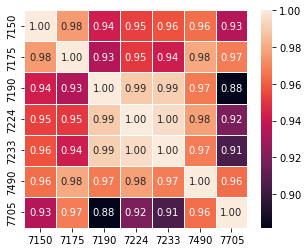

In [74]:
# Imprime o mapa de correlação - estímulos neutros
plt.figure(figsize=(5,4))
ax = plt.axes()
sns.heatmap(correlation_neutral, annot = True, fmt=".2f", linewidths=.6, ax = ax)
#ax.set_title('Estímulos Neutros', fontsize = 12)
plt.savefig('correlation_neutral.pdf', format='pdf', bbox_inches='tight')

In [75]:
# Cria dataframa para armazenar dados
df_anova_neutral = pd.DataFrame({'Signal': df_cor_neutral.unstack(),
                                  'Class': np.repeat([neutral,],repeats=len(e_neutral))})
# Realiza comparações pareadas múltiplas (Tukey HSD)
m_comp_neutral = pairwise_tukeyhsd(endog=df_anova_neutral['Signal'], groups=df_anova_neutral['Class'], alpha=0.05)
print(m_comp_neutral)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
7150.jpg 7175.jpg   0.2314 0.001  0.2087  0.2542   True
7150.jpg 7190.jpg  -0.0671 0.001 -0.0898 -0.0444   True
7150.jpg 7224.jpg  -0.1475 0.001 -0.1702 -0.1248   True
7150.jpg 7233.jpg  -0.2024 0.001 -0.2251 -0.1796   True
7150.jpg 7490.jpg  -0.1835 0.001 -0.2062 -0.1607   True
7150.jpg 7705.jpg  -0.0023   0.9  -0.025  0.0204  False
7175.jpg 7190.jpg  -0.2986 0.001 -0.3213 -0.2759   True
7175.jpg 7224.jpg  -0.3789 0.001 -0.4016 -0.3562   True
7175.jpg 7233.jpg  -0.4338 0.001 -0.4565 -0.4111   True
7175.jpg 7490.jpg  -0.4149 0.001 -0.4376 -0.3922   True
7175.jpg 7705.jpg  -0.2337 0.001 -0.2564  -0.211   True
7190.jpg 7224.jpg  -0.0804 0.001 -0.1031 -0.0576   True
7190.jpg 7233.jpg  -0.1352 0.001 -0.1579 -0.1125   True
7190.jpg 7490.jpg  -0.1163 0.001  -0.139 -0.0936   True
7190.jpg 7705.jpg   0.0648 0.001  0.0421  0.0876

In [76]:
# Classe de estímulos negativos
# Prepara dataframe para análise de correlação
df_cor_negative = pd.DataFrame({
    negative[0][:4]: s_negative[0],
    negative[1][:4]: s_negative[1],
    negative[2][:4]: s_negative[2],
    negative[3][:4]: s_negative[3],
    negative[4][:4]: s_negative[4],
    negative[5][:4]: s_negative[5],
    negative[6][:4]: s_negative[6]
})
# Calcula a correlação das curvas 
correlation_negative = df_cor_negative.corr()
correlation_negative

2722      9220      7521      9001      2205      6010      3220
2722  1.000000  0.958425  0.909723  0.986171  0.951929  0.920553  0.926842
9220  0.958425  1.000000  0.985711  0.957316  0.959468  0.972569  0.977872
7521  0.909723  0.985711  1.000000  0.908271  0.931919  0.977706  0.970732
9001  0.986171  0.957316  0.908271  1.000000  0.958756  0.903714  0.921316
2205  0.951929  0.959468  0.931919  0.958756  1.000000  0.895135  0.903208
6010  0.920553  0.972569  0.977706  0.903714  0.895135  1.000000  0.975490
3220  0.926842  0.977872  0.970732  0.921316  0.903208  0.975490  1.000000

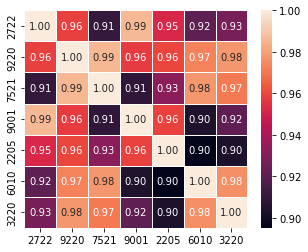

In [77]:
# Imprime o mapa de correlação - estímulos negativos
plt.figure(figsize=(5,4))
ax = plt.axes()
sns.heatmap(correlation_negative, annot = True, fmt=".2f", linewidths=.6, ax = ax)
#ax.set_title('Estímulos Negativos', fontsize = 12)
plt.savefig('correlation_negative.pdf', format='pdf', bbox_inches='tight')

In [78]:
# Cria dataframa para armazenar dados
df_anova_negative = pd.DataFrame({'Signal': df_cor_negative.unstack(),
                                  'Class': np.repeat([negative,],repeats=len(e_negative))})
# Realiza comparações pareadas múltiplas (Tukey HSD)
m_comp_negative = pairwise_tukeyhsd(endog=df_anova_negative['Signal'], groups=df_anova_negative['Class'], alpha=0.05)
print(m_comp_negative)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
2205.jpg 2722.jpg   0.1289  0.001  0.1092  0.1486   True
2205.jpg 3220.jpg   0.0171 0.1345 -0.0025  0.0368  False
2205.jpg 6010.jpg   0.0897  0.001    0.07  0.1093   True
2205.jpg 7521.jpg  -0.3787  0.001 -0.3983  -0.359   True
2205.jpg 9001.jpg   0.0321  0.001  0.0124  0.0517   True
2205.jpg 9220.jpg  -0.0499  0.001 -0.0696 -0.0303   True
2722.jpg 3220.jpg  -0.1118  0.001 -0.1314 -0.0921   True
2722.jpg 6010.jpg  -0.0392  0.001 -0.0589 -0.0196   True
2722.jpg 7521.jpg  -0.5076  0.001 -0.5272 -0.4879   True
2722.jpg 9001.jpg  -0.0968  0.001 -0.1165 -0.0772   True
2722.jpg 9220.jpg  -0.1788  0.001 -0.1985 -0.1592   True
3220.jpg 6010.jpg   0.0725  0.001  0.0529  0.0922   True
3220.jpg 7521.jpg  -0.3958  0.001 -0.4155 -0.3762   True
3220.jpg 9001.jpg   0.0149 0.2756 -0.0047  0.0346  False
3220.jpg 9220.jpg  -0.0671  0.0

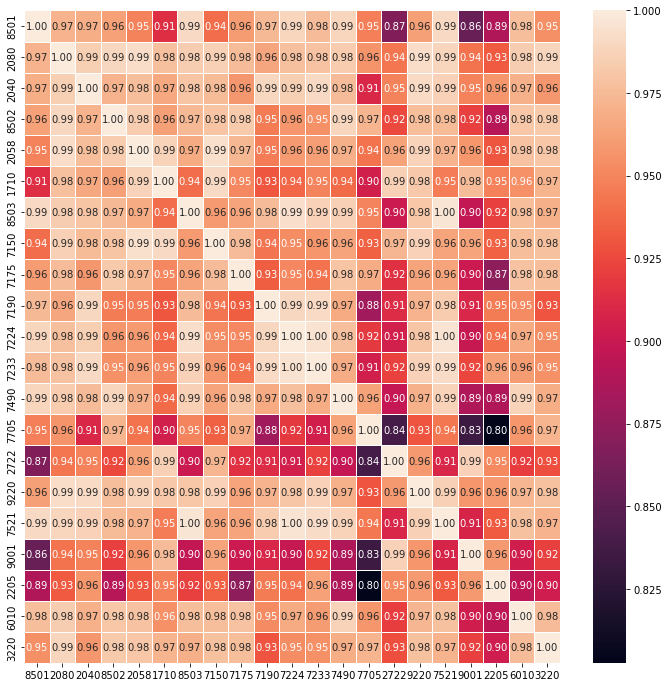

In [79]:
# Prepara dataframe para análise de correlação total por estímulo
df_cor_total = pd.concat([df_cor_positive, df_cor_neutral, df_cor_negative], axis=1)
df_cor_total
# Calcula a correlação das curvas 
correlation_total = df_cor_total.corr()
# Imprime o mapa de correlação - estímulos negativos
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_total,annot = True, fmt=".2f", linewidths=.6)
plt.savefig('correlation_total.pdf', format='pdf', bbox_inches='tight')